# Buisness problem

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Project Objectives**

Provider Fraud is one of the biggest problems facing Medicare. According to the government, the total Medicare spending increased exponentially due to frauds in Medicare claims. Healthcare fraud is an organized crime which involves peers of providers, physicians, beneficiaries acting together to make fraud claims.

Rigorous analysis of Medicare data has yielded many physicians who indulge in fraud. They adopt ways in which an ambiguous diagnosis code is used to adopt costliest procedures and drugs. Insurance companies are the most vulnerable institutions impacted due to these bad practices. Due to this reason, insurance companies increased their insurance premiums and as result healthcare is becoming costly matter day by day.


**Types of frauds**

Healthcare fraud and abuse take many forms. Some of the most common types of frauds by providers are:

a) Billing for services that were not provided.

b) Duplicate submission of a claim for the same service.

c) Misrepresenting the service provided.

d) Charging for a more complex or expensive service than was actually provided.

e) Billing for a covered service when the service actually provided was not covered.


**Objective**

The goal of this project is to " predict the potentially fraudulent providers " based on the claims filed by them.along with this, we will also discover important variables helpful in detecting the behaviour of potentially fraud providers. further, we will study fraudulent patterns in the provider's claims to understand the future behaviour of providers.


**Data we will be working with**

For the purpose of this project, we are considering Inpatient claims, Outpatient claims and Beneficiary details of each provider. Lets s see their details :

A) Inpatient Data

This data provides insights about the claims filed for those patients who are admitted in the hospitals. It also provides additional details like their admission and discharge dates and admit d diagnosis code.

B) Outpatient Data

This data provides details about the claims filed for those patients who visit hospitals and not admitted in it.

C) Beneficiary Details Data

This data contains beneficiary KYC details like health conditions,regioregion they belong to etc.

D)Train Data:

Data containing provider id's and whether they are fraud or not.



**Approach**:

We are given with no details about the health care provider except for the *provider id*. But in inpatient and out paient files we have *provider id* as feature. So we can leverage that and generate information about the provider based on the details of patients.

In [ ]:
#importing dependencies
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
ben_data=pd.read_csv('/content/drive/MyDrive/Train_Beneficiarydata-1542865627584.csv')
inp_data=pd.read_csv('/content/drive/MyDrive/Train_Inpatientdata-1542865627584.csv')
out_data=pd.read_csv('/content/drive/MyDrive/Train_Outpatientdata-1542865627584.csv')
train_data=pd.read_csv('/content/drive/MyDrive/Train-1542865627584.csv')

##EDA

**Train data**

In [ ]:
def bar_plot(x,y,xlab=None,ylab=None,title=None,annotate=False):
  '''This function generates an annotated barplot'''
  fig,ax=plt.subplots(figsize=(8,6))
  custom_palette=['dark:salmon_r','ocean','inferno','BrBG','binary','winter']
  choice=random.choice(custom_palette)
  if title is not None:
    ax.set_title(title)
  else:
    ax.set_title('No title')  
  sns.barplot(x=x,
            y=y,palette=choice,alpha=0.8,edgecolor='black',linewidth=2)
  ax.patch.set_edgecolor('black')  
  ax.patch.set_linewidth('2')
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  if annotate==True:
    for p in ax.patches:
      ax.annotate(p.get_height(), (p.get_x()+p.get_width()/3. * 1.005, p.get_height() * .5))
  plt.show()    

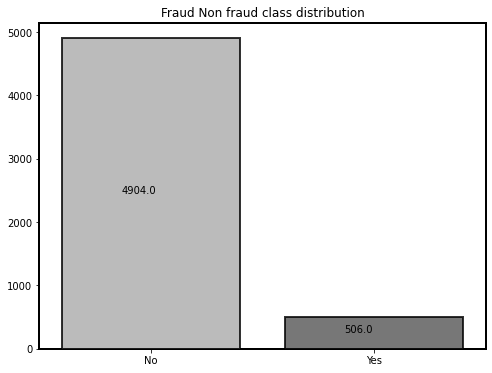

Only 9.35% of healthcare providers are fraudulent 


In [ ]:
bar_plot(train_data.PotentialFraud.value_counts().index,train_data.PotentialFraud.value_counts().values,title='Fraud Non fraud class distribution',annotate=True)
plt.show()
print('Only {0:.2f}% of healthcare providers are fraudulent '.format(train_data.PotentialFraud.value_counts()[1]/5410*100))

From above plot we observe that there is a severe class imbalance.

**Inp data**

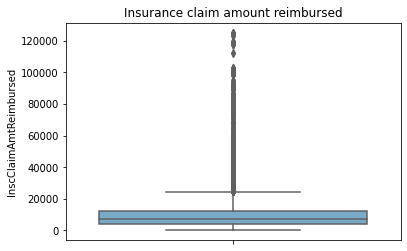

In [ ]:
#Insurance claim reimbursed
plt.title('Insurance claim amount reimbursed')
sns.boxplot(y=inp_data.InscClaimAmtReimbursed,palette='Blues')
plt.show()

We see a large amount of outliers in this data.Most patients seem to have humble claim amounts while some having huge claims.

In [ ]:
#Physician data
print('Missing values in attending physician',inp_data.AttendingPhysician.isnull().sum())
print('Missing values in operating physician',inp_data.OperatingPhysician.isnull().sum())
print('Missing values in other physician',inp_data.OtherPhysician.isnull().sum())

Missing values in attending physician 112
Missing values in operating physician 16644
Missing values in other physician 35784


Most patients might not require a operation procedure i.e it seems for most patients the attending physician is sufficient. We will treat it as such while handling missing values.

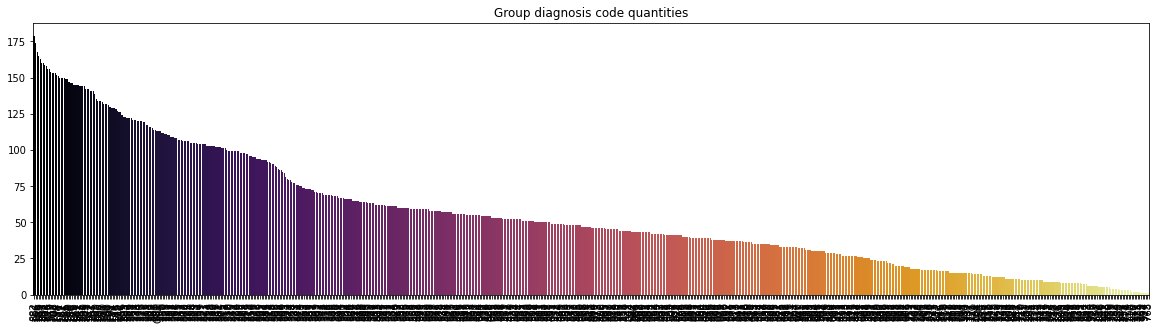

Top 10 diagnosis codes are 
 882    179
884    174
166    168
183    165
939    163
168    160
883    160
887    159
204    158
945    156
Name: DiagnosisGroupCode, dtype: int64


In [ ]:
# Group diagnosis code
plt.figure(figsize=(20,5))
plt.title('Group diagnosis code quantities')
sns.barplot(x=inp_data.DiagnosisGroupCode.value_counts().index,y=inp_data.DiagnosisGroupCode.value_counts().values,palette='inferno')
plt.xticks(rotation=90)
plt.show()
print('Top 10 diagnosis codes are \n',inp_data.DiagnosisGroupCode.value_counts()[:10])

**Outpatient data**

Much more outpatient claims than inpatient. Similar reducing trend is also observed here.

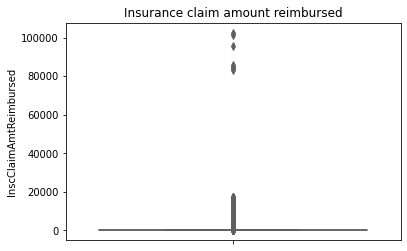

In [ ]:
#Outpatient InsclaimReimb
plt.title('Insurance claim amount reimbursed')
sns.boxplot(y=out_data.InscClaimAmtReimbursed,palette='Blues')
# plt.ylim(0,1000)
plt.show()

Outliers seem to be very separated from frequently occuring data but not much is clear..

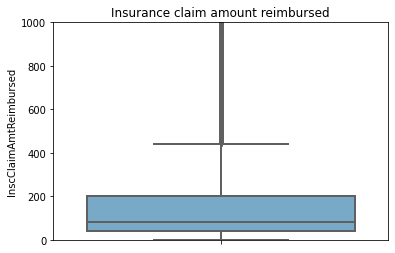

In [ ]:
plt.title('Insurance claim amount reimbursed')
sns.boxplot(y=out_data.InscClaimAmtReimbursed,palette='Blues',linewidth=2)
plt.ylim(0,1000)
plt.show()

Most outdoor patients seem to have claims under 400

In [ ]:
print('Missing values in attending physician',out_data.AttendingPhysician.isnull().sum())
print('Missing values in operating physician',out_data.OperatingPhysician.isnull().sum())
print('Missing values in other physician',out_data.OtherPhysician.isnull().sum())

Missing values in attending physician 1396
Missing values in operating physician 427120
Missing values in other physician 322691


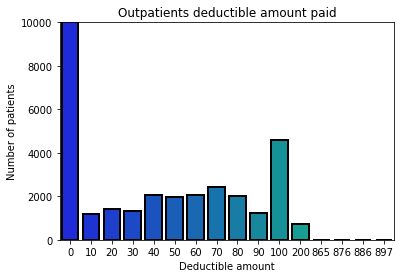

Total number of patients who not paid deductible amount 496701


In [ ]:
plt.title('Outpatients deductible amount paid')
sns.barplot(x=out_data.DeductibleAmtPaid.value_counts().index,y=out_data.DeductibleAmtPaid.value_counts().values,palette='winter',linewidth=2,edgecolor='black')
plt.xlabel('Deductible amount')
plt.ylabel('Number of patients')
plt.ylim(0,10000)
plt.show()
print('Total number of patients who not paid deductible amount',out_data.DeductibleAmtPaid.value_counts()[0])

Most patients do not have to pay any kind of deductible amount.This amount is probably be paid by the government.

**Benefeciary data**

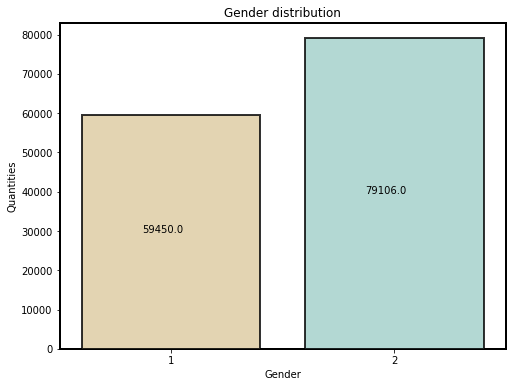

In [ ]:
bar_plot(ben_data.Gender.value_counts().index,ben_data.Gender.value_counts().values,'Gender','Quantities','Gender distribution',True)

We see a minor imbalance between genders nothing to worry about.

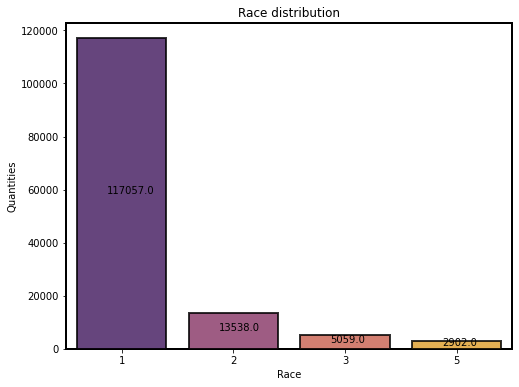

In [ ]:
bar_plot(ben_data.Race.value_counts().index,ben_data.Race.value_counts().values,xlab='Race',ylab='Quantities',title='Race distribution',annotate=True)

**Merging inpatient+outpatient+benefeciary+provider**


In [ ]:
#merging inpatient and outpatient data
cols=list(set(inp_data.columns).intersection(set(out_data.columns)))
patient=inp_data.merge(out_data,how='outer',on=cols)

In [ ]:
patient_int=ben_data.merge(patient,how='outer',on='BeneID')

In [ ]:
patient_fin=patient_int.merge(train_data,how='outer',on='Provider')

Now we have the target variable so we can visualize interaction features.

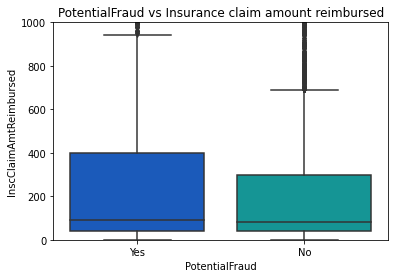

In [ ]:
plt.title('PotentialFraud vs Insurance claim amount reimbursed')
sns.boxplot(y='InscClaimAmtReimbursed',x='PotentialFraud',data=patient_fin,palette='winter')
plt.ylim(0,1000)
plt.show()

The upper whisker in the boxplot is higher for fraudulent transaction than non fraudulent. 

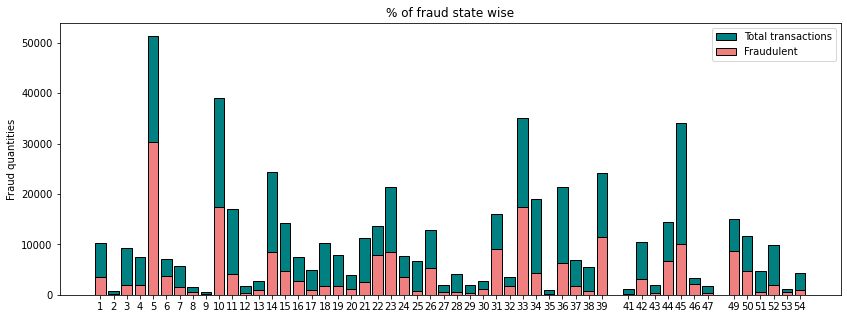

In [ ]:
temp1=patient_fin.groupby('State')['PotentialFraud'].agg(lambda x:x.eq('Yes').sum()).reset_index() #aggregates state wise potential fraud
temp2=patient_fin.groupby('State')['PotentialFraud'].agg(lambda x:x.eq('No').sum()).reset_index()
temp3=temp1['PotentialFraud']+temp2['PotentialFraud']
plt.figure(figsize=(14,5))
plt.title('State vs Potential Fraud')
p1=plt.bar(temp1['State'],temp3,edgecolor='black',color='teal')
p2=plt.bar(temp1['State'],temp1['PotentialFraud'],edgecolor='black',color='lightcoral')
plt.ylabel('Fraud quantities')
plt.title('% of fraud state wise')
plt.xticks(temp1['State'], list(temp1['State'].values))
plt.legend((p1[0], p2[0]), ('Total transactions', 'Fraudulent'))
plt.show()
#code for simple annotation
# for p in ax.patches:
#   ax.annotate(p.get_height(), (p.get_x()+p.get_width()/3. * 1.005, p.get_height() * 1.005))

In states 5,10,33 & 45 transactions are high and fraudulent transactions are also high.

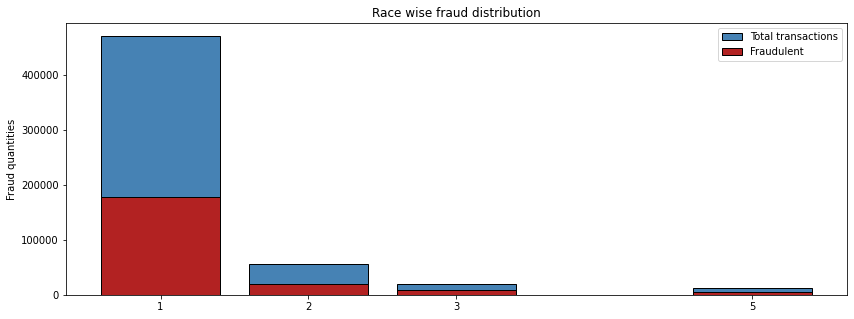

% fraud transactions racewise


[(1, 0.37862286534362555),
 (2, 0.36455787203450757),
 (3, 0.45457773269084456),
 (5, 0.4403553299492386)]

In [ ]:
temp1=patient_fin.groupby('Race')['PotentialFraud'].agg(lambda x:x.eq('Yes').sum()).reset_index()
temp2=patient_fin.groupby('Race')['PotentialFraud'].agg(lambda x:x.eq('No').sum()).reset_index()
temp3=temp1['PotentialFraud']+temp2['PotentialFraud']
plt.figure(figsize=(14,5))
plt.title('Race vs Potential Fraud')
p1=plt.bar(temp1['Race'],temp3,edgecolor='black',color='steelblue')
p2=plt.bar(temp1['Race'],temp1['PotentialFraud'],edgecolor='black',color='firebrick')
plt.ylabel('Fraud quantities')
plt.title('Race wise fraud distribution')
plt.xticks(temp1['Race'], list(temp1['Race'].values))
plt.legend((p1[0], p2[0]), ('Total transactions', 'Fraudulent'))
plt.show()
print('% fraud transactions racewise')
[(temp1['Race'].loc[i],temp1['PotentialFraud'].loc[i]/temp3[i]) for i in range(len(temp1['PotentialFraud']))]

-There are no race 4 persons in dataset.

-Patients of race 3 and 5 are more susceptible to fraud

In [ ]:
#label coding binary features
cols=['ChronicCond_Alzheimer','ChronicCond_Heartfailure','ChronicCond_KidneyDisease',
      'ChronicCond_Cancer','ChronicCond_ObstrPulmonary','ChronicCond_Depression','ChronicCond_Diabetes',
      'ChronicCond_IschemicHeart','ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis',
      'ChronicCond_stroke']
for i in cols:
  patient_fin[i]=patient_fin[i].map({1:0,2:1})

In [ ]:
patient_fin.RenalDiseaseIndicator=patient_fin.RenalDiseaseIndicator.map({'0':0,'Y':1})

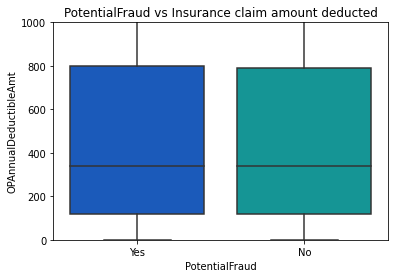

In [ ]:
plt.title('PotentialFraud vs Insurance claim amount deducted')
sns.boxplot(y='OPAnnualDeductibleAmt',x='PotentialFraud',data=patient_fin,palette='winter')
plt.ylim(0,1000)
plt.show()

Deductible amount is very similar for fraud and non fraud.

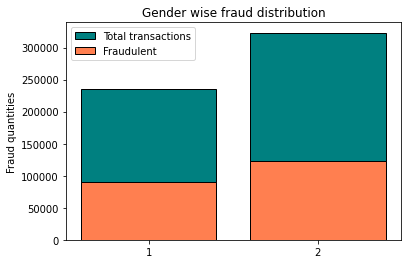

% fraud transactions Genderwise


[(1, 0.38147232844315326), (2, 0.38102032100125655)]

In [ ]:
temp1=patient_fin.groupby('Gender')['PotentialFraud'].agg(lambda x:x.eq('Yes').sum()).reset_index()
temp2=patient_fin.groupby('Gender')['PotentialFraud'].agg(lambda x:x.eq('No').sum()).reset_index()
temp3=temp1['PotentialFraud']+temp2['PotentialFraud']
plt.figure(figsize=(6,4))
plt.title('Gender vs Potential Fraud')
p1=plt.bar(temp1['Gender'],temp3,edgecolor='black',color='teal')
p2=plt.bar(temp1['Gender'],temp1['PotentialFraud'],edgecolor='black',color='coral')
plt.ylabel('Fraud quantities')
plt.title('Gender wise fraud distribution')
plt.xticks(temp1['Gender'], list(temp1['Gender'].values))
plt.legend((p1[0], p2[0]), ('Total transactions', 'Fraudulent'))
plt.show()
print('% fraud transactions Genderwise')
[(temp1['Gender'].loc[i],temp1['PotentialFraud'].loc[i]/temp3[i]) for i in range(len(temp1['PotentialFraud']))]

In [ ]:
patient_fin.to_csv('patient_fin.csv')

Both genders are equally prone to fraud.

This concludes our EDA. Next on to feature engineering.